In [1]:
from importlib import import_module

In [2]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk
from ase.io import write
from ase.atoms import Atoms
from adis_tools.parsers import parse_pw

In [3]:
from jobflow import job, Flow
from jobflow.managers.local import run_locally

In [4]:
def get_function_dict(flow):
    return {
        job.uuid: job.function
        for job in flow.jobs
    }

In [5]:
def get_nodes_dict(function_dict):
    nodes_dict, nodes_mapping_dict = {}, {}
    # function_dict_len = len(function_dict)
    for i, [k, v] in enumerate(function_dict.items()):
        # nodes_dict[function_dict_len-i] = v
        # nodes_mapping_dict[k] = function_dict_len-i
        nodes_dict[i] = v
        nodes_mapping_dict[k] = i
    
    return nodes_dict, nodes_mapping_dict

In [6]:
def get_edge_from_dict(target, key, value_dict, nodes_mapping_dict):
    if len(value_dict['attributes']) == 1:
        return {'target': target, 'targetHandle': key, "source": nodes_mapping_dict[value_dict['uuid']], 'sourceHandle': value_dict['attributes'][0][1]}
    else:
        return {'target': target, 'targetHandle': key, "source": nodes_mapping_dict[value_dict['uuid']], 'sourceHandle': None}

In [7]:
def get_edges_and_extend_nodes(flow_dict, nodes_mapping_dict, nodes_dict):
    edges_lst = []
    for job in flow_dict['jobs']:
        for k, v in job['function_kwargs'].items():
            if isinstance(v, dict) and '@module' in v and '@class' in v and '@version' in v:
                edges_lst.append(get_edge_from_dict(
                    target=nodes_mapping_dict[job["uuid"]], 
                    key=k, 
                    value_dict=v, 
                    nodes_mapping_dict=nodes_mapping_dict,
                ))
            elif isinstance(v, dict) and any([isinstance(el, dict) and '@module' in el and '@class' in el and '@version' in el for el in v.values()]):
                # print("found link in dict", v)
                node_dict_index = len(nodes_dict)
                nodes_dict[node_dict_index] = get_dict
                for kt, vt in v.items():
                    if isinstance(vt, dict) and '@module' in vt and '@class' in vt and '@version' in vt:
                        edges_lst.append(get_edge_from_dict(
                            target=node_dict_index, 
                            key=kt, 
                            value_dict=vt, 
                            nodes_mapping_dict=nodes_mapping_dict,
                        ))
                    else:
                        if vt not in nodes_dict.values():
                            node_index = len(nodes_dict)
                            nodes_dict[node_index] = vt
                        else:
                            # print(nodes_dict, vt)
                            node_index = {str(tv): tk for tk, tv in nodes_dict.items()}[str(vt)]
                        edges_lst.append({'target': node_dict_index, 'targetHandle': kt, "source": node_index, 'sourceHandle': None})
                edges_lst.append({'target': nodes_mapping_dict[job["uuid"]], 'targetHandle': k, "source": node_dict_index, 'sourceHandle': None})
            elif isinstance(v, list) and any([isinstance(el, dict) and '@module' in el and '@class' in el and '@version' in el for el in v]):
                # print("found link in list", v)
                node_list_index = len(nodes_dict)
                nodes_dict[node_list_index] = get_list
                for kt, vt in enumerate(v):
                    if isinstance(vt, dict) and '@module' in vt and '@class' in vt and '@version' in vt:
                        edges_lst.append(get_edge_from_dict(
                            target=node_list_index, 
                            key=str(kt), 
                            value_dict=vt, 
                            nodes_mapping_dict=nodes_mapping_dict,
                        ))
                    else:
                        if vt not in nodes_dict.values():
                            node_index = len(nodes_dict)
                            nodes_dict[node_index] = vt
                        else:
                            # print(nodes_dict, vt)
                            node_index = {str(tv): tk for tk, tv in nodes_dict.items()}[str(vt)]
                        edges_lst.append({'target': node_list_index, 'targetHandle': kt, "source": node_index, 'sourceHandle': None})
                edges_lst.append({'target': nodes_mapping_dict[job["uuid"]], 'targetHandle': k, "source": node_list_index, 'sourceHandle': None})
            else:
                if v not in nodes_dict.values():
                    node_index = len(nodes_dict)
                    nodes_dict[node_index] = v
                else:
                    node_index = {tv: tk for tk, tv in nodes_dict.items()}[v]
                edges_lst.append({'target': nodes_mapping_dict[job["uuid"]], 'targetHandle': k, "source": node_index, 'sourceHandle': None})
    return edges_lst, nodes_dict

In [8]:
def get_dict(**kwargs):
    return {k: v for k, v in kwargs.items()}

In [9]:
def get_list(**kwargs):
    return list(kwargs.values())

In [10]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, "input.pwi")
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename,
        images=Atoms(**input_dict["structure"]),
        Crystal=True,
        kpts=input_dict["kpts"],
        input_data={
            "calculation": input_dict["calculation"],
            "occupations": "smearing",
            "degauss": input_dict["smearing"],
        },
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True,
        tprnfor=True,
    )

In [11]:
def collect_output(working_directory="."):
    output = parse_pw(os.path.join(working_directory, "pwscf.xml"))
    return {
        "structure": output["ase_structure"].todict(),
        "energy": output["energy"],
        "volume": output["ase_structure"].get_volume(),
    }

In [12]:
@job(data=["energy", "volume", "structure"])
def calculate_qe(working_directory, input_dict):
    write_input(
        input_dict=input_dict,
        working_directory=working_directory,
    )
    subprocess.check_output(
        "mpirun -np 1 pw.x -in input.pwi > output.pwo",
        cwd=working_directory,
        shell=True,
    )
    return collect_output(working_directory=working_directory)

In [13]:
@job(data=["i" for i in range(100)])  # maximum number of strains is currently 100 
def generate_structures(structure, strain_lst):
    structure_lst = []
    for strain in strain_lst:
        structure_strain = Atoms(**structure)
        structure_strain.set_cell(
            structure_strain.cell * strain ** (1 / 3), scale_atoms=True
        )
        structure_lst.append(structure_strain)
    return {str(i): s.todict() for i, s in enumerate(structure_lst)}

In [14]:
@job
def plot_energy_volume_curve(volume_lst, energy_lst):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

In [15]:
@job
def get_bulk_structure(name, a, cubic):
    return bulk(
        name=name,
        a=a,
        cubic=cubic,
    ).todict()

In [16]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [17]:
structure = get_bulk_structure(
    name="Al",
    a=4.05,
    cubic=True,
)

In [18]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure.output,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [19]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
)

In [20]:
job_strain_lst = []
for i in range(number_of_strains):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": getattr(structure_lst.output, str(i)),
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [21]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [22]:
flow = Flow([structure, calc_mini, structure_lst] + job_strain_lst + [plot])

In [23]:
flow_dict = flow.as_dict()

In [24]:
function_dict = get_function_dict(flow=flow)
function_dict

{'e556acdb-0504-4ee8-9230-556b6204d556': <function __main__.get_bulk_structure(name, a, cubic)>,
 'e9b6361d-0b18-4c6c-88f3-e247a0659e34': <function __main__.calculate_qe(working_directory, input_dict)>,
 'db93730a-db3f-4d00-8ec9-2f7111f4245e': <function __main__.generate_structures(structure, strain_lst)>,
 '1ad51625-8409-4820-bf12-6ffda8cb9e8a': <function __main__.calculate_qe(working_directory, input_dict)>,
 '5d22fd8f-62b6-4aa6-bc57-baacd91750cb': <function __main__.calculate_qe(working_directory, input_dict)>,
 '3a3b9a2a-5f77-4182-a402-0452c7d99269': <function __main__.calculate_qe(working_directory, input_dict)>,
 'cb06da66-213b-4df3-81a7-6ba7a117efda': <function __main__.calculate_qe(working_directory, input_dict)>,
 'c2b91326-cc79-4251-b468-b6b14b45ed07': <function __main__.calculate_qe(working_directory, input_dict)>,
 '385493c9-e2fe-4237-9b33-ca3bb3481e75': <function __main__.plot_energy_volume_curve(volume_lst, energy_lst)>}

In [25]:
nodes_dict, nodes_mapping_dict = get_nodes_dict(function_dict=function_dict)
nodes_dict

{0: <function __main__.get_bulk_structure(name, a, cubic)>,
 1: <function __main__.calculate_qe(working_directory, input_dict)>,
 2: <function __main__.generate_structures(structure, strain_lst)>,
 3: <function __main__.calculate_qe(working_directory, input_dict)>,
 4: <function __main__.calculate_qe(working_directory, input_dict)>,
 5: <function __main__.calculate_qe(working_directory, input_dict)>,
 6: <function __main__.calculate_qe(working_directory, input_dict)>,
 7: <function __main__.calculate_qe(working_directory, input_dict)>,
 8: <function __main__.plot_energy_volume_curve(volume_lst, energy_lst)>}

In [26]:
nodes_mapping_dict

{'e556acdb-0504-4ee8-9230-556b6204d556': 0,
 'e9b6361d-0b18-4c6c-88f3-e247a0659e34': 1,
 'db93730a-db3f-4d00-8ec9-2f7111f4245e': 2,
 '1ad51625-8409-4820-bf12-6ffda8cb9e8a': 3,
 '5d22fd8f-62b6-4aa6-bc57-baacd91750cb': 4,
 '3a3b9a2a-5f77-4182-a402-0452c7d99269': 5,
 'cb06da66-213b-4df3-81a7-6ba7a117efda': 6,
 'c2b91326-cc79-4251-b468-b6b14b45ed07': 7,
 '385493c9-e2fe-4237-9b33-ca3bb3481e75': 8}

In [27]:
edges_lst, nodes_dict = get_edges_and_extend_nodes(flow_dict=flow_dict, nodes_mapping_dict=nodes_mapping_dict, nodes_dict=nodes_dict)
nodes_dict

{0: <function __main__.get_bulk_structure(name, a, cubic)>,
 1: <function __main__.calculate_qe(working_directory, input_dict)>,
 2: <function __main__.generate_structures(structure, strain_lst)>,
 3: <function __main__.calculate_qe(working_directory, input_dict)>,
 4: <function __main__.calculate_qe(working_directory, input_dict)>,
 5: <function __main__.calculate_qe(working_directory, input_dict)>,
 6: <function __main__.calculate_qe(working_directory, input_dict)>,
 7: <function __main__.calculate_qe(working_directory, input_dict)>,
 8: <function __main__.plot_energy_volume_curve(volume_lst, energy_lst)>,
 9: 'Al',
 10: 4.05,
 11: True,
 12: 'mini',
 13: <function __main__.get_dict(**kwargs)>,
 14: {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'},
 15: [3, 3, 3],
 16: 'vc-relax',
 17: 0.02,
 18: [0.9, 0.9500000000000001, 1.0, 1.05, 1.1],
 19: 'strain_0',
 20: <function __main__.get_dict(**kwargs)>,
 21: 'scf',
 22: 'strain_1',
 23: <function __main__.get_dict(**kwargs)>,
 24: 'strain_2',
 25:

In [28]:
edges_lst

[{'target': 0, 'targetHandle': 'name', 'source': 9, 'sourceHandle': None},
 {'target': 0, 'targetHandle': 'a', 'source': 10, 'sourceHandle': None},
 {'target': 0, 'targetHandle': 'cubic', 'source': 11, 'sourceHandle': None},
 {'target': 1,
  'targetHandle': 'working_directory',
  'source': 12,
  'sourceHandle': None},
 {'target': 13,
  'targetHandle': 'structure',
  'source': 0,
  'sourceHandle': None},
 {'target': 13,
  'targetHandle': 'pseudopotentials',
  'source': 14,
  'sourceHandle': None},
 {'target': 13, 'targetHandle': 'kpts', 'source': 15, 'sourceHandle': None},
 {'target': 13,
  'targetHandle': 'calculation',
  'source': 16,
  'sourceHandle': None},
 {'target': 13,
  'targetHandle': 'smearing',
  'source': 17,
  'sourceHandle': None},
 {'target': 1,
  'targetHandle': 'input_dict',
  'source': 13,
  'sourceHandle': None},
 {'target': 2,
  'targetHandle': 'structure',
  'source': 1,
  'sourceHandle': 'structure'},
 {'target': 2,
  'targetHandle': 'strain_lst',
  'source': 18,


2025-01-17 12:45:33,746 INFO Started executing jobs locally
2025-01-17 12:45:34,630 INFO Starting job - get_bulk_structure (e556acdb-0504-4ee8-9230-556b6204d556)
2025-01-17 12:45:34,635 INFO Finished job - get_bulk_structure (e556acdb-0504-4ee8-9230-556b6204d556)
2025-01-17 12:45:34,636 INFO Starting job - calculate_qe (e9b6361d-0b18-4c6c-88f3-e247a0659e34)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 12:45:47,865 INFO Finished job - calculate_qe (e9b6361d-0b18-4c6c-88f3-e247a0659e34)
2025-01-17 12:45:47,866 INFO Starting job - generate_structures (db93730a-db3f-4d00-8ec9-2f7111f4245e)
2025-01-17 12:45:47,873 INFO Finished job - generate_structures (db93730a-db3f-4d00-8ec9-2f7111f4245e)
2025-01-17 12:45:47,873 INFO Starting job - calculate_qe (1ad51625-8409-4820-bf12-6ffda8cb9e8a)
2025-01-17 12:45:50,873 INFO Finished job - calculate_qe (1ad51625-8409-4820-bf12-6ffda8cb9e8a)
2025-01-17 12:45:50,874 INFO Starting job - calculate_qe (5d22fd8f-62b6-4aa6-bc57-baacd91750cb)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 12:45:54,119 INFO Finished job - calculate_qe (5d22fd8f-62b6-4aa6-bc57-baacd91750cb)
2025-01-17 12:45:54,120 INFO Starting job - calculate_qe (3a3b9a2a-5f77-4182-a402-0452c7d99269)
2025-01-17 12:45:57,541 INFO Finished job - calculate_qe (3a3b9a2a-5f77-4182-a402-0452c7d99269)
2025-01-17 12:45:57,542 INFO Starting job - calculate_qe (cb06da66-213b-4df3-81a7-6ba7a117efda)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 12:46:01,329 INFO Finished job - calculate_qe (cb06da66-213b-4df3-81a7-6ba7a117efda)
2025-01-17 12:46:01,330 INFO Starting job - calculate_qe (c2b91326-cc79-4251-b468-b6b14b45ed07)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 12:46:05,185 INFO Finished job - calculate_qe (c2b91326-cc79-4251-b468-b6b14b45ed07)
2025-01-17 12:46:05,185 INFO Starting job - plot_energy_volume_curve (385493c9-e2fe-4237-9b33-ca3bb3481e75)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 12:46:05,277 INFO Finished job - plot_energy_volume_curve (385493c9-e2fe-4237-9b33-ca3bb3481e75)
2025-01-17 12:46:05,278 INFO Finished executing jobs locally


{'e556acdb-0504-4ee8-9230-556b6204d556': {1: Response(output={'numbers': array([13, 13, 13, 13]), 'positions': array([[0.   , 0.   , 0.   ],
         [0.   , 2.025, 2.025],
         [2.025, 0.   , 2.025],
         [2.025, 2.025, 0.   ]]), 'cell': array([[4.05, 0.  , 0.  ],
         [0.  , 4.05, 0.  ],
         [0.  , 0.  , 4.05]]), 'pbc': array([ True,  True,  True])}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/janssen/notebooks/2025/2025-01-16-jobflow-qe'))},
 'e9b6361d-0b18-4c6c-88f3-e247a0659e34': {1: Response(output={'structure': {'numbers': array([13, 13, 13, 13]), 'positions': array([[0.        , 0.        , 0.        ],
         [0.        , 2.02281861, 2.02281861],
         [2.02281861, 0.        , 2.02281861],
         [2.02281861, 2.02281861, 0.        ]]), 'cell': array([[4.04563722, 0.        , 0.        ],
         [0.        , 4.04563722, 0.        ],
         [0.        , 0.        , 4.045

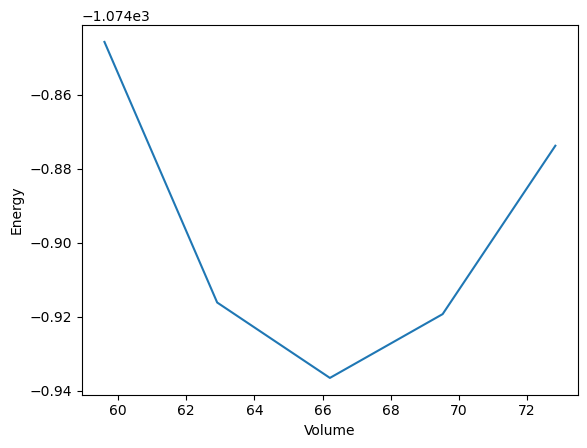

In [29]:
result = run_locally(flow)
result